In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import export_graphviz
from IPython.display import Image
import os

# 设置随机种子以确保可重复性
RSEED = 50

In [2]:
#读取数据
data = pd.read_excel(r"BreastCancer.xlsx",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,904971,1,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,...,12.40,25.58,82.76,472.4,0.1363,0.16440,0.141200,0.07887,0.2251,0.07732
1,9010877,1,13.40,16.95,85.48,552.4,0.07937,0.05696,0.021810,0.014730,...,14.73,21.70,93.76,663.5,0.1213,0.16760,0.136400,0.06987,0.2741,0.07582
2,8911230,1,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,...,12.20,18.99,77.37,458.0,0.1259,0.07348,0.004955,0.01111,0.2758,0.06386
3,9112085,1,13.38,30.72,86.34,557.2,0.09245,0.07426,0.028190,0.032640,...,15.05,41.61,96.69,705.6,0.1172,0.14210,0.070030,0.07763,0.2196,0.07675
4,89511501,1,12.20,15.21,78.01,457.9,0.08673,0.06545,0.019940,0.016920,...,13.75,21.38,91.11,583.1,0.1256,0.19280,0.116700,0.05556,0.2661,0.07961


In [44]:
data[1].value_counts()

1    357
2    212
Name: 1, dtype: int64

In [3]:
#数据处理

#删除第一列数据
data.pop(0)
#取得并删除标签
labels = np.array(data.pop(1))

In [4]:
#

data.head()

,2,3,4,5,6,7,8,9,10,11,...,22,23,24,25,26,27,28,29,30,31
0,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,0.1486,0.06615,...,12.40,25.58,82.76,472.4,0.1363,0.16440,0.141200,0.07887,0.2251,0.07732
1,13.40,16.95,85.48,552.4,0.07937,0.05696,0.021810,0.014730,0.1650,0.05701,...,14.73,21.70,93.76,663.5,0.1213,0.16760,0.136400,0.06987,0.2741,0.07582
2,11.33,14.16,71.79,396.6,0.09379,0.03872,0.001487,0.003333,0.1954,0.05821,...,12.20,18.99,77.37,458.0,0.1259,0.07348,0.004955,0.01111,0.2758,0.06386
3,13.38,30.72,86.34,557.2,0.09245,0.07426,0.028190,0.032640,0.1375,0.06016,...,15.05,41.61,96.69,705.6,0.1172,0.14210,0.070030,0.07763,0.2196,0.07675
4,12.20,15.21,78.01,457.9,0.08673,0.06545,0.019940,0.016920,0.1638,0.06129,...,13.75,21.38,91.11,583.1,0.1256,0.19280,0.116700,0.05556,0.2661,0.07961


In [5]:
# 30%的样本作为测试数据
train, test, train_labels, test_labels = train_test_split(data, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = 0)

In [6]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances特征重要性
features = list(train.columns)

In [7]:
#训练数据
train.shape

(398, 30)

In [8]:
#测试数据
test.shape

(171, 30)

In [9]:
# 训练
tree = DecisionTreeClassifier(random_state=RSEED)
tree.fit(train, train_labels)
print(f'决策树有 {tree.tree_.node_count} 个节点，最大深度为 {tree.tree_.max_depth}.')

决策树有 33 个节点，最大深度为 6.


In [10]:
# 进行概率预测
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [11]:

print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, probs)}')

训练的 ROC AUC : 1.0
测试的 ROC AUC : 0.9329001168224299


In [12]:
print(f'基本Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

基本Baseline ROC AUC: 0.5


In [13]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels-1, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels-1, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [14]:

print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 106, 1.0: 65})
Counter({1: 106, 2: 65})


Recall Baseline: 1.0 Test: 0.94 Train: 1.0
Precision Baseline: 0.63 Test: 0.95 Train: 1.0
Roc Baseline: 0.5 Test: 0.93 Train: 1.0


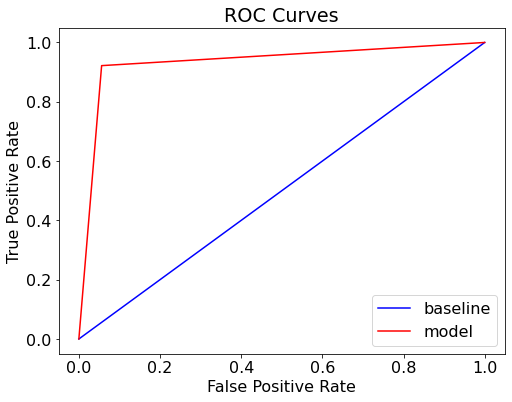

In [15]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[101   6]
 [  5  59]]


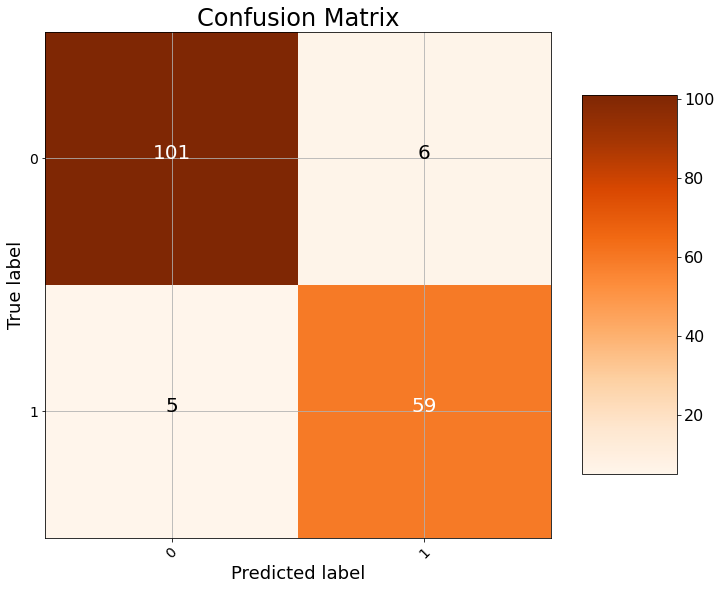

In [17]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [18]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
20,22,0.712322
27,29,0.140016
21,23,0.046647
11,13,0.031807
23,25,0.018824


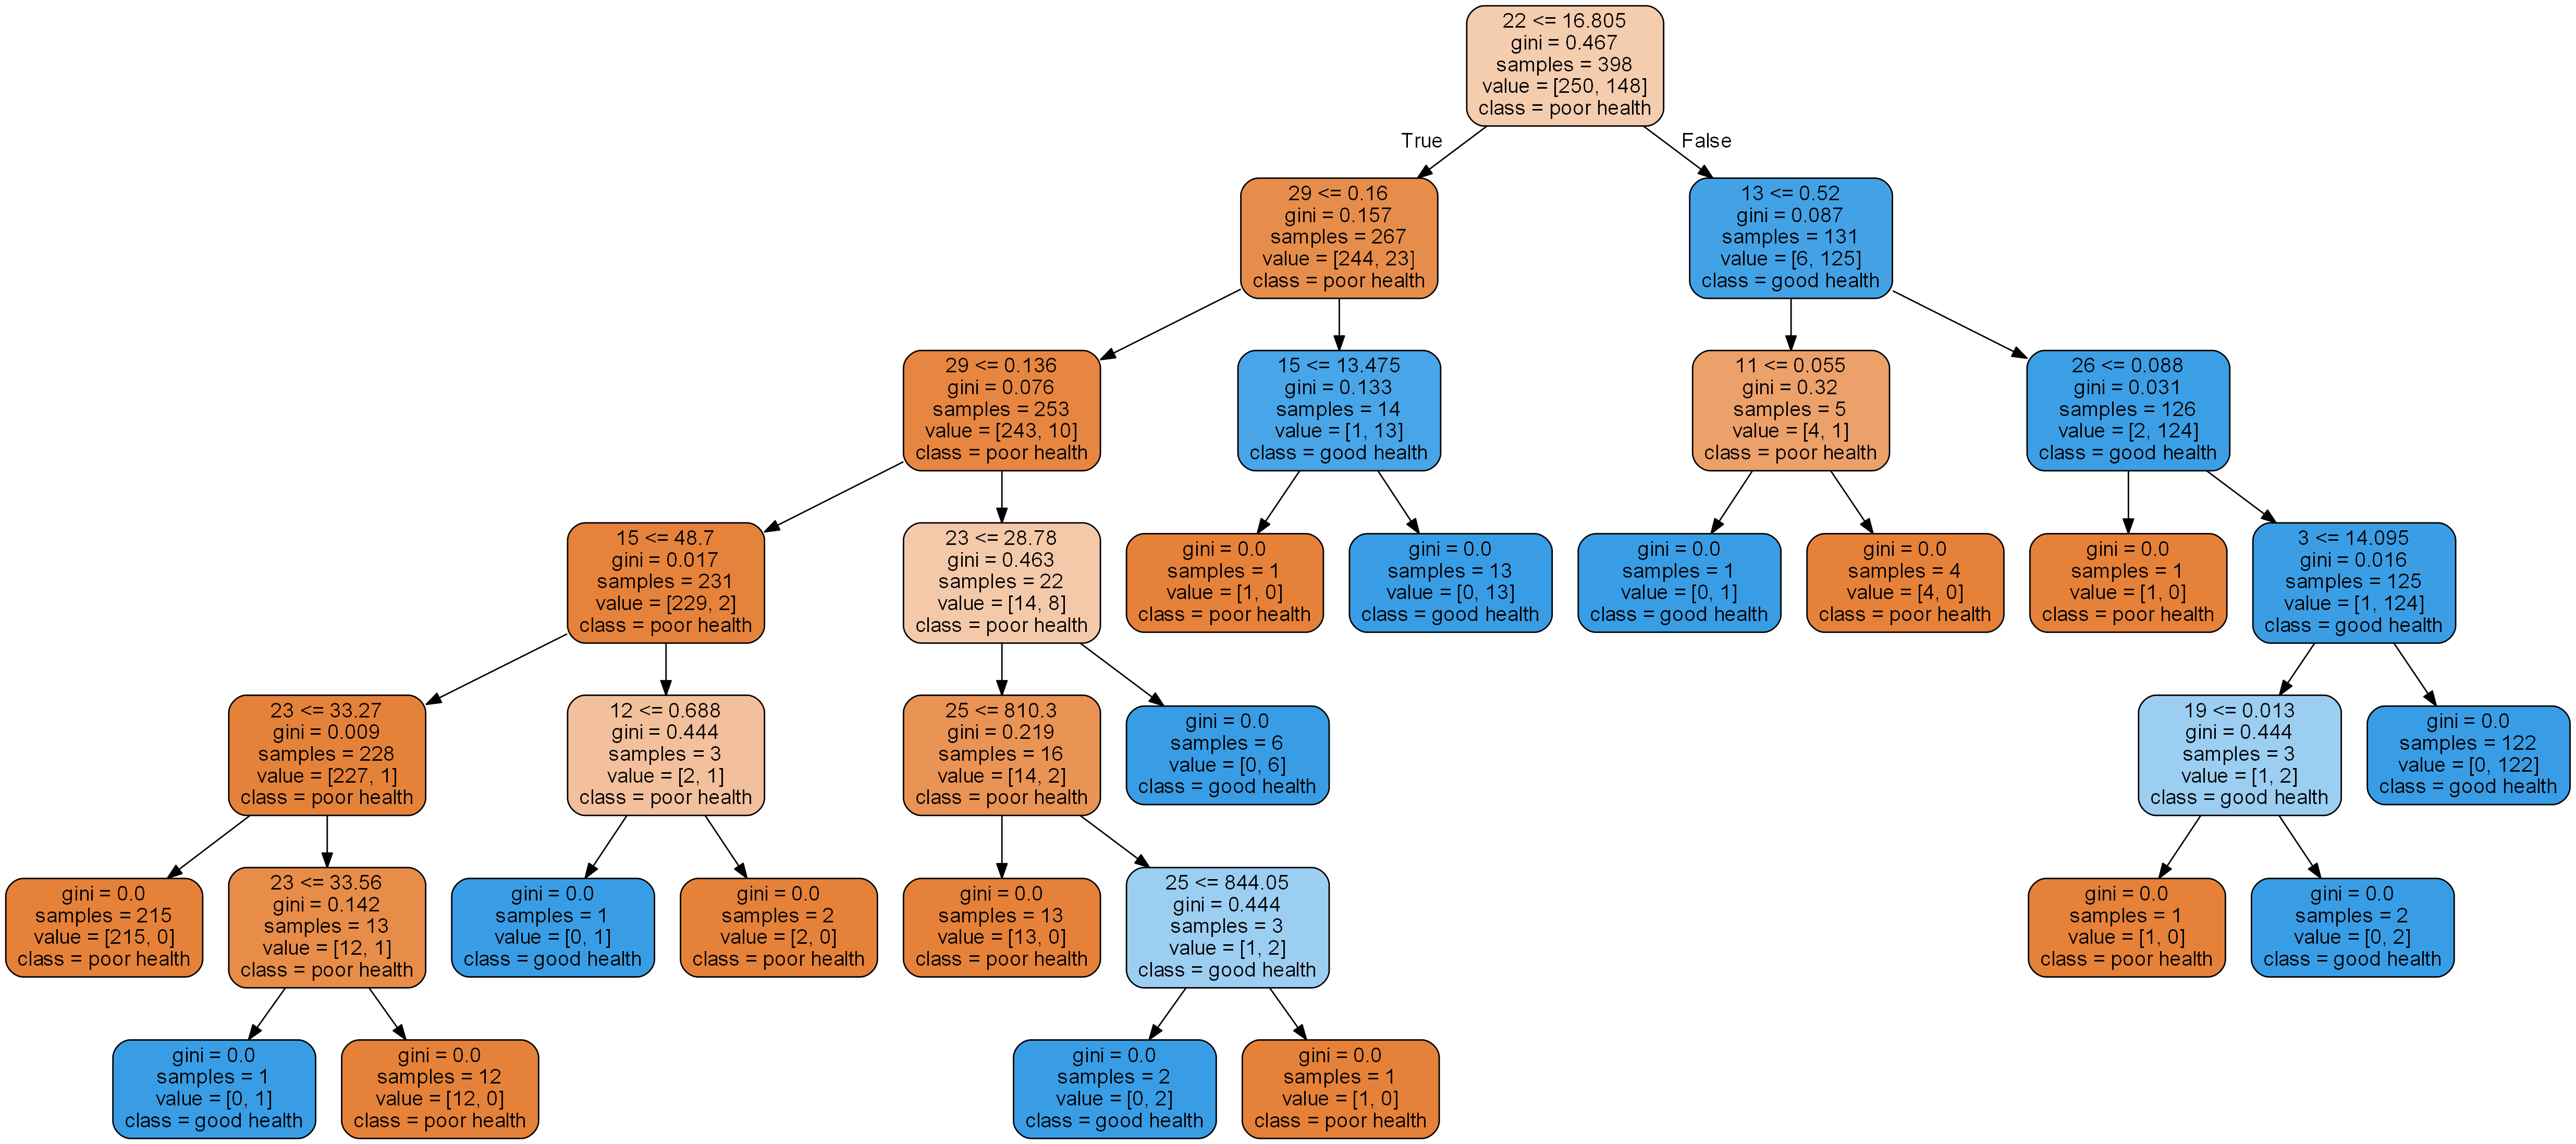

In [19]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
cmd = 'dot -Tpng tree_real_data.dot -o tree_real_data.png -Gdpi=200'
os.system(cmd)
# Visualize
Image(filename='tree_real_data.png')

In [20]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [21]:
accuracy = evaluate(tree, test, test_labels)

Model Performance
Average Error: 0.0643 degrees.
Accuracy = 95.03%.


In [22]:
from sklearn.ensemble import RandomForestClassifier

# 创建100个树的模型
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

In [23]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 31
Average maximum depth 6


In [ ]:

# 进行概率预测
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)
print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, probs)}')

In [24]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_rf_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, rf_probs)}')

训练的 ROC AUC : 1.0
测试的 ROC AUC : 0.9917494158878505


Recall Baseline: 1.0 Test: 0.95 Train: 1.0
Precision Baseline: 0.63 Test: 0.96 Train: 1.0
Roc Baseline: 0.5 Test: 0.99 Train: 1.0


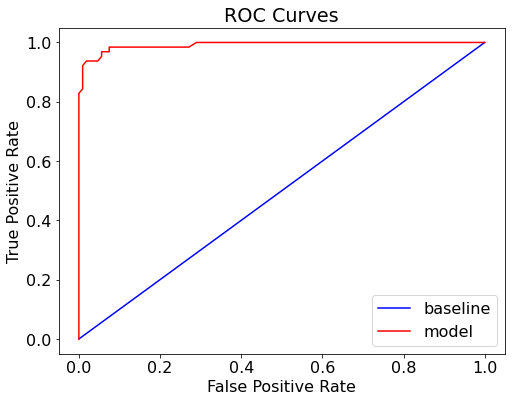

In [68]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [69]:
estimator = model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree11111forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

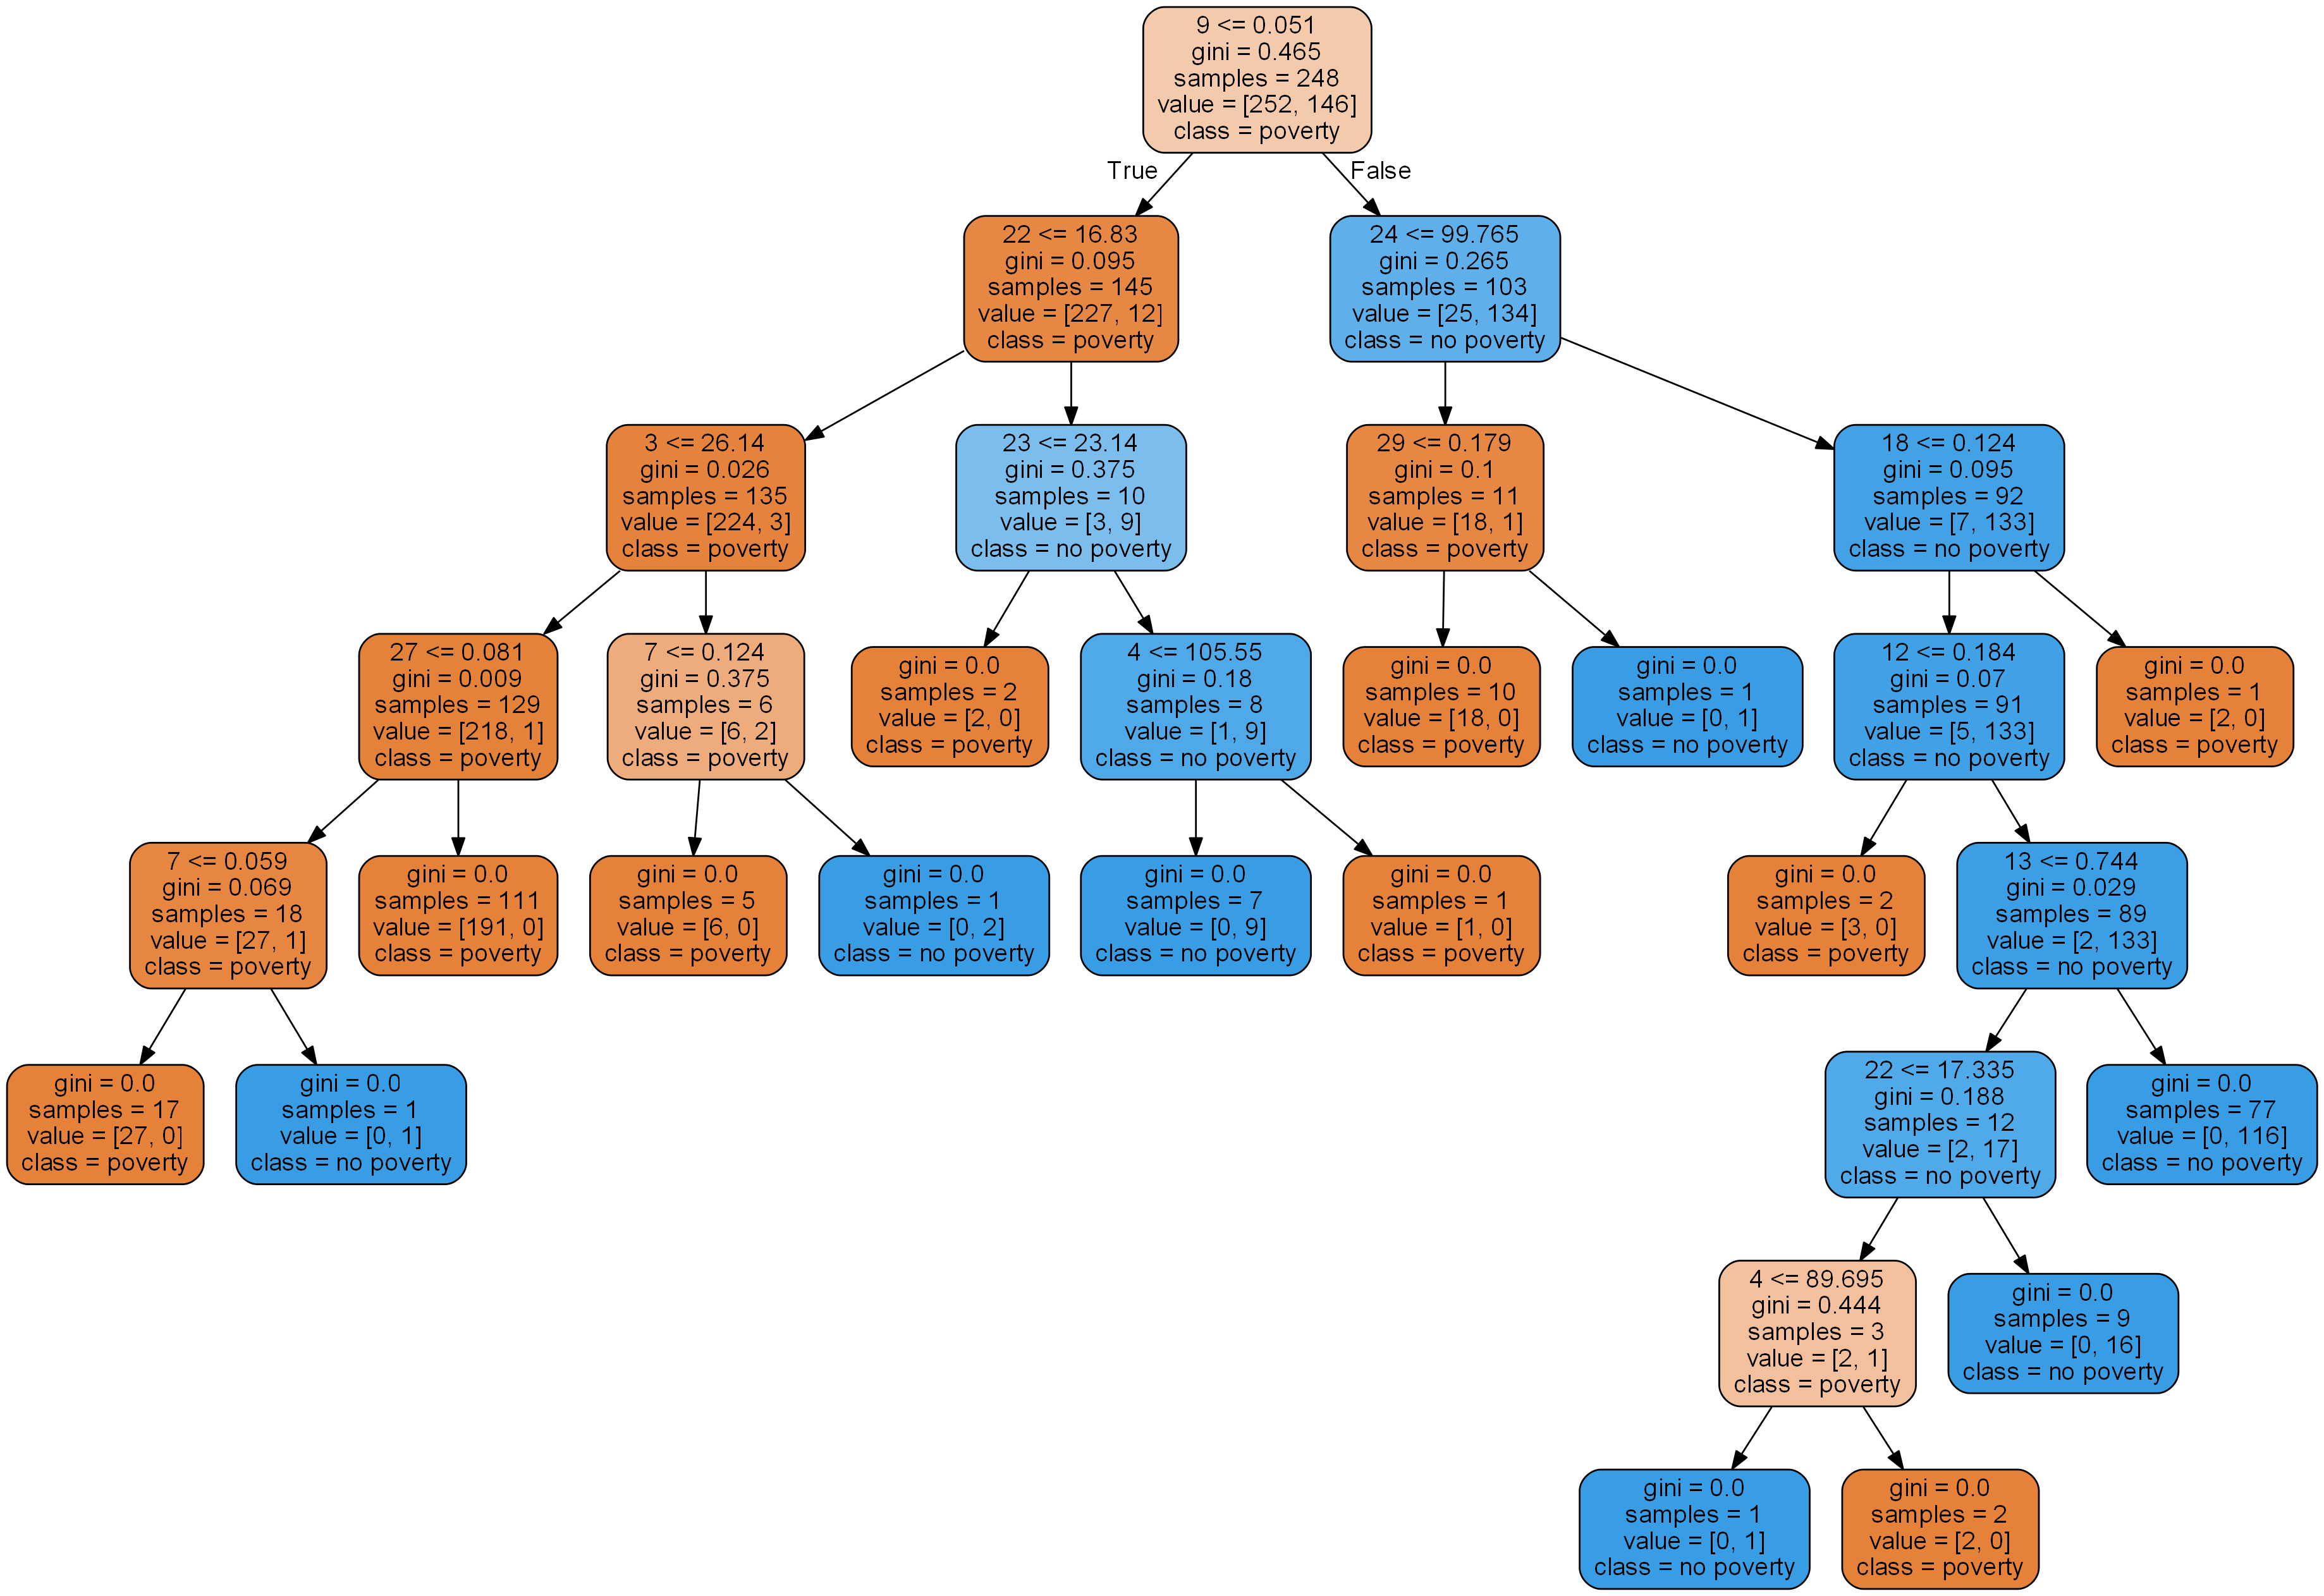

In [70]:
cmd = 'dot -Tpng tree11111forest.dot -o tree11111forest.png -Gdpi=200'
os.system(cmd)
Image('tree11111forest.png')

Confusion matrix, without normalization
[[102   5]
 [  4  60]]


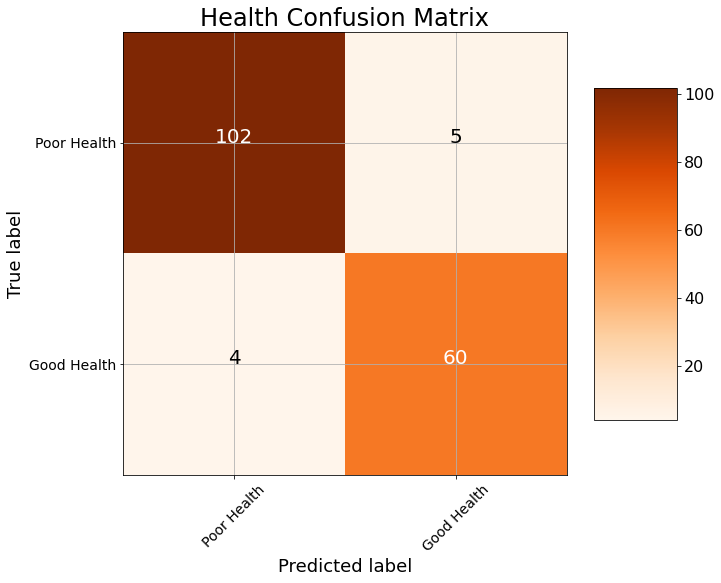

In [71]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Health Confusion Matrix')

In [28]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
20,22,0.157815
27,29,0.153720
22,24,0.144609
7,9,0.119670
23,25,0.113310
0,2,0.036414
13,15,0.035157
6,8,0.034470
3,5,0.033219
26,28,0.019789


In [73]:
accuracy = evaluate(model, test, test_labels)

Model Performance
Average Error: 0.0526 degrees.
Accuracy = 95.91%.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
#通过随机搜索优化随机森林
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5,1,0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [46]:
rs.best_params_

{'n_estimators': 25,
 'min_samples_split': 5,
 'max_leaf_nodes': 17,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [56]:
best_model = rs.best_estimator_

In [57]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [58]:

# 进行概率预测
predictions = tree.predict(test)
print(f'训练的 ROC AUC : {roc_auc_score(train_labels, train_rf_probs)}')
print(f'测试的 ROC AUC : {roc_auc_score(test_labels, rf_probs)}')

训练的 ROC AUC : 0.9988108108108108
测试的 ROC AUC : 0.9883177570093458


In [50]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 19
Average maximum depth 4


Recall Baseline: 1.0 Test: 0.95 Train: 1.0
Precision Baseline: 0.63 Test: 0.96 Train: 0.98
Roc Baseline: 0.5 Test: 0.99 Train: 1.0


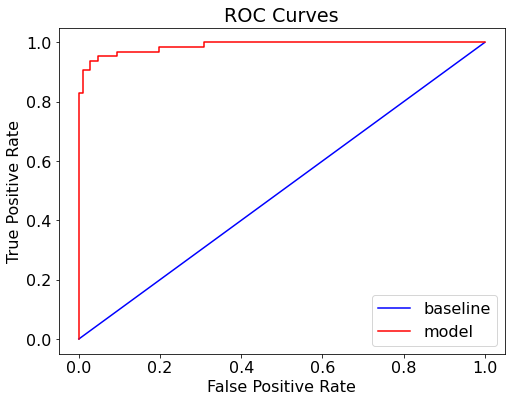

In [51]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[102   5]
 [  4  60]]


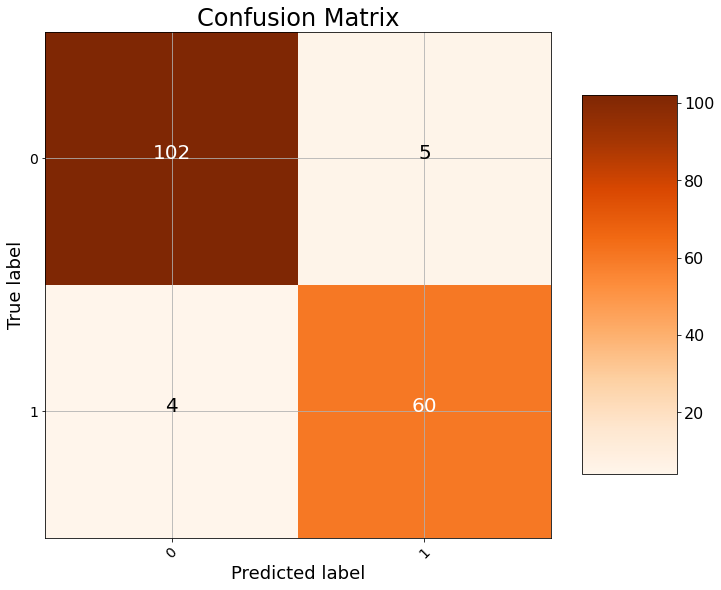

In [52]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [53]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
20,22,0.157815
27,29,0.153720
22,24,0.144609
7,9,0.119670
23,25,0.113310
0,2,0.036414
13,15,0.035157
6,8,0.034470
3,5,0.033219
26,28,0.019789


In [54]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

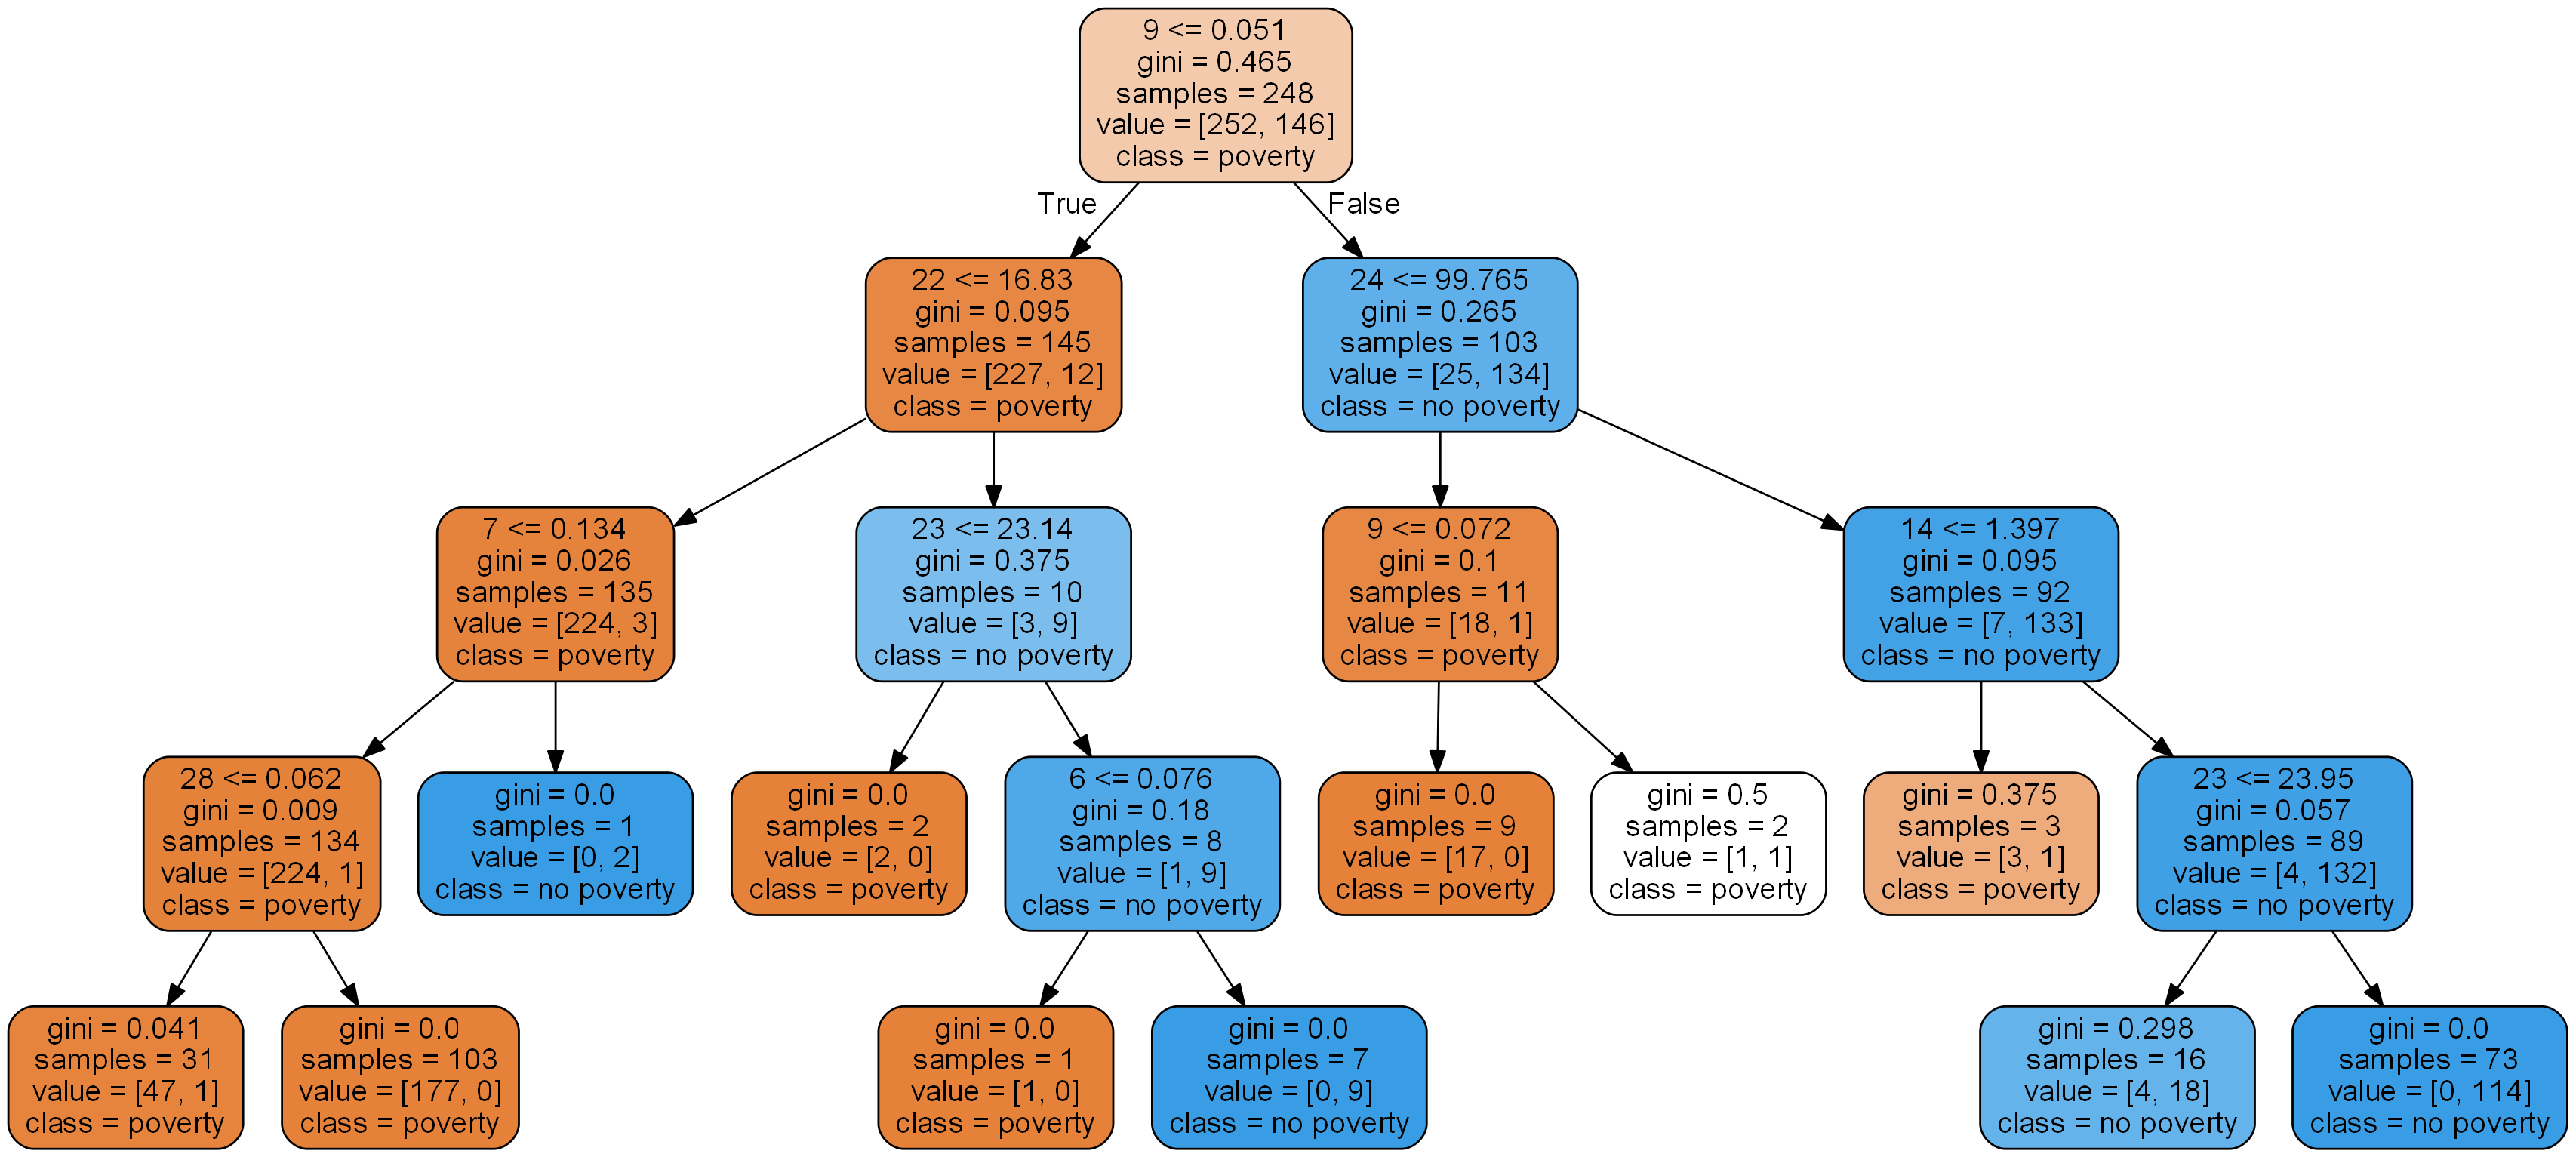

In [55]:
cmd = 'dot -Tpng tree_from_optimized_forest.dot -o tree_from_optimized_forest.png -Gdpi=200'
os.system(cmd)
Image('tree_from_optimized_forest.png')

In [84]:
random_accuracy = evaluate(best_model, test, test_labels)

Model Performance
Average Error: 0.0526 degrees.
Accuracy = 95.91%.


# Grid Search 

In [108]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 4, 5, 6],
    'max_features': ['auto'],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [5, 20, 30, 50]
}

# Create a base model
rf = RandomForestClassifier(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [109]:
grid_search.fit(train, train_labels)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto'],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [5, 20, 30, 50]},
             return_train_score=True, verbose=2)

In [110]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 20}

In [111]:
random_accuracy = evaluate(grid_search, test, test_labels)

Model Performance
Average Error: 0.0585 degrees.
Accuracy = 95.32%.


In [112]:
grid_model = grid_search.best_estimator_
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [113]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 19
Average maximum depth 4


Recall Baseline: 1.0 Test: 0.95 Train: 1.0
Precision Baseline: 0.63 Test: 0.96 Train: 0.98
Roc Baseline: 0.5 Test: 0.99 Train: 1.0


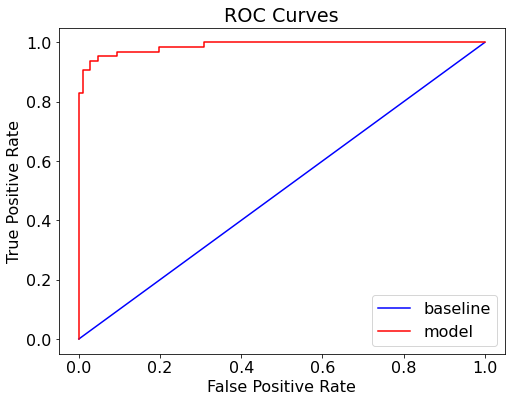

In [114]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [115]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_grid_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

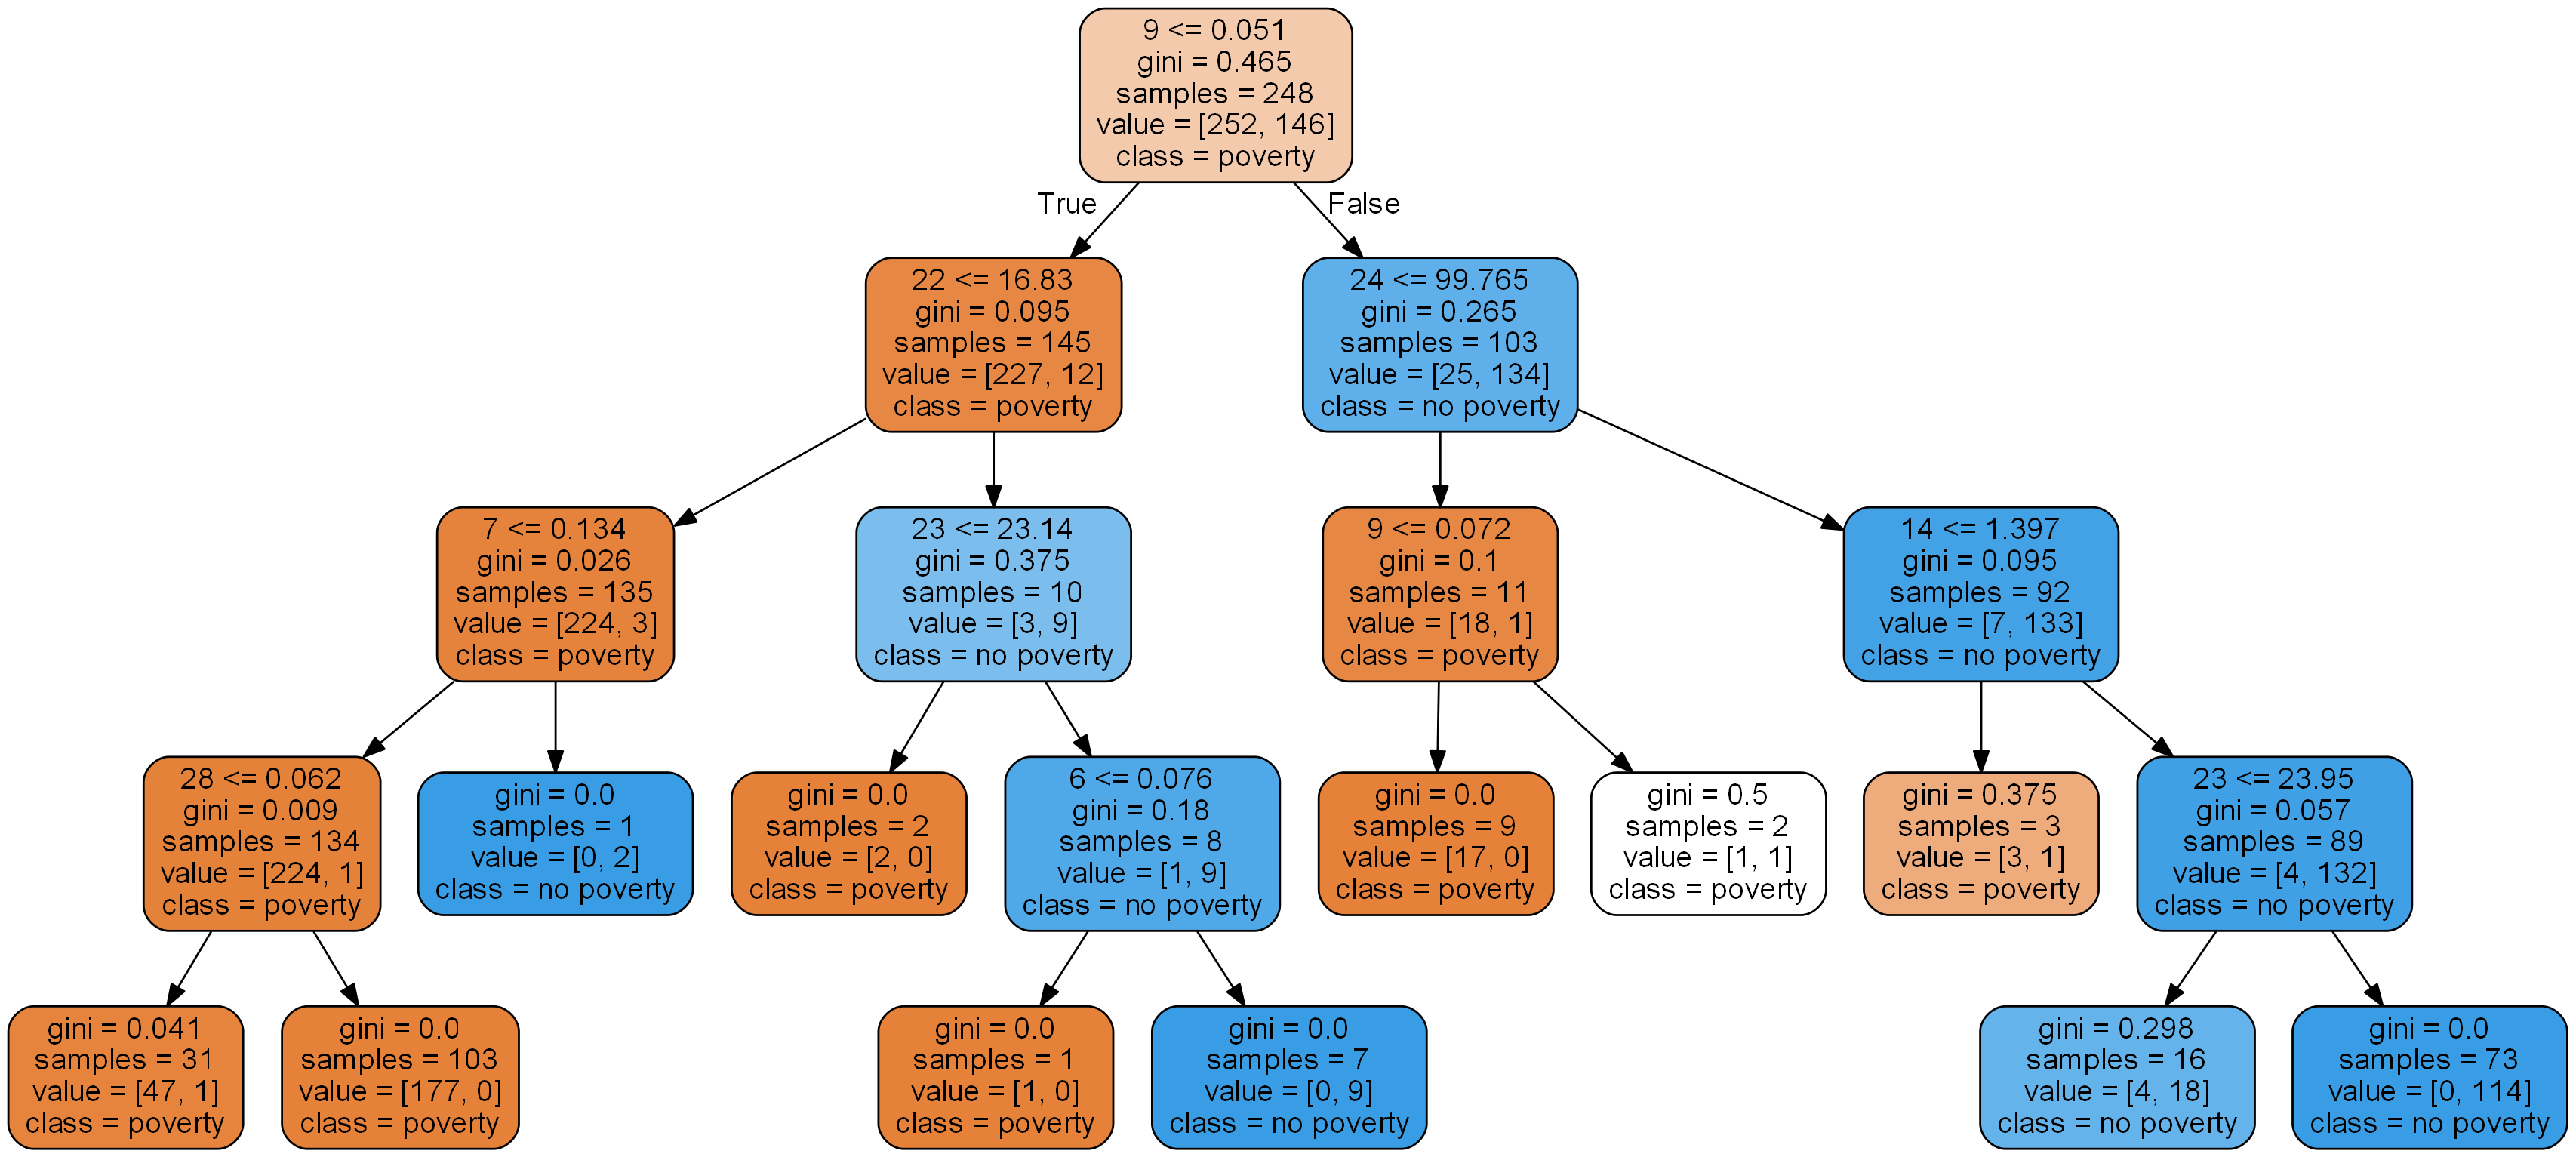

In [116]:
cmd = 'dot -Tpng tree_grid_optimized_forest.dot -o tree_grid_optimized_forest.png -Gdpi=200'
os.system(cmd)
Image('tree_grid_optimized_forest.png')